# Manufacturing Defect Prediction: Two-Stage Forecasting System

This notebook implements a comprehensive two-stage approach for predicting manufacturing defects 30-60 minutes in advance:

**Stage 1**: LSTM-based sensor forecasting to predict future sensor trajectories  
**Stage 2**: Classification model using current + forecasted sensor features to predict defect probability

**Key Requirements**:
- Forecast horizon: 30-60 minutes (180-360 time steps at 10-second intervals)
- Input sequence: 60 minutes (360 time steps)
- Target sensors: main_comp, tbl_speed, SREL, tbl_fill
- Defect threshold: 0.7 probability for yellow flag alert
- Quality criteria: Drug release average < 90%, impurities/solvents above limits


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import xgboost as xgb

# Utility libraries
import glob
import os
from datetime import datetime, timedelta
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)


In [ ]:
# Enhanced downsampling utilities based on NumPy techniques
import math

def downsample_time_series(df, target_interval_seconds=60, aggregation_method='mean'):
    """
    Downsample time series data from 10-second intervals to larger intervals for memory efficiency.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time series dataframe with timestamp column
    target_interval_seconds : int
        Target sampling interval in seconds (default: 60 = 1 minute)
    aggregation_method : str
        Method for aggregation ('mean', 'max', 'last', 'multiple')
        
    Returns:
    --------
    pd.DataFrame
        Downsampled dataframe
    """
    print(f"Downsampling from ~10s to {target_interval_seconds}s intervals...")
    print(f"Original shape: {df.shape}")
    
    # Sort by batch and timestamp
    df = df.sort_values(['batch', 'timestamp']).copy()
    
    # Define sensor columns for aggregation
    sensor_columns = ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 
                     'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']
    
    downsampled_batches = []
    
    for batch_id in df['batch'].unique():
        batch_data = df[df['batch'] == batch_id].copy()
        
        if len(batch_data) < 6:  # Skip batches with too few data points
            continue
            
        # Create time bins based on target interval
        batch_data['time_bin'] = (batch_data['time_in_batch'] // target_interval_seconds).astype(int)
        
        if aggregation_method == 'multiple':
            # Use multiple aggregation methods to preserve more information
            agg_dict = {}
            
            # For sensor columns, use multiple aggregations
            for col in sensor_columns:
                if col in batch_data.columns:
                    agg_dict[f'{col}_mean'] = (col, 'mean')
                    agg_dict[f'{col}_max'] = (col, 'max')
                    agg_dict[f'{col}_std'] = (col, 'std')
            
            # For other columns, use appropriate aggregations
            agg_dict.update({
                'timestamp': ('timestamp', 'first'),
                'campaign': ('campaign', 'first'),
                'code': ('code', 'first'),
                'defect': ('defect', 'first'),
                'file_id': ('file_id', 'first'),
                'hour': ('hour', 'first'),
                'day_of_week': ('day_of_week', 'first'),
                'time_in_batch': ('time_in_batch', 'mean')
            })
            
        else:
            # Single aggregation method
            agg_dict = {}
            for col in sensor_columns:
                if col in batch_data.columns:
                    agg_dict[col] = aggregation_method
            
            agg_dict.update({
                'timestamp': 'first',
                'campaign': 'first',
                'code': 'first',
                'defect': 'first',
                'file_id': 'first',
                'hour': 'first',
                'day_of_week': 'first',
                'time_in_batch': 'mean'
            })
        
        # Perform aggregation
        batch_downsampled = batch_data.groupby('time_bin').agg(agg_dict).reset_index()
        
        # If using multiple aggregation, flatten column names
        if aggregation_method == 'multiple':
            batch_downsampled.columns = [col[0] if col[1] == '' else col[1] if col[0] == '' else f"{col[1]}" 
                                       for col in batch_downsampled.columns]
        
        # Add batch identifier
        batch_downsampled['batch'] = batch_id
        
        downsampled_batches.append(batch_downsampled)
    
    # Combine all batches
    result_df = pd.concat(downsampled_batches, ignore_index=True)
    result_df = result_df.sort_values(['batch', 'timestamp']).reset_index(drop=True)
    
    print(f"Downsampled shape: {result_df.shape}")
    print(f"Memory reduction factor: {df.shape[0] / result_df.shape[0]:.1f}x")
    print(f"Downsampling completed!")
    
    return result_df

def create_memory_efficient_sequences(df, input_minutes=60, forecast_minutes=30, 
                                    target_sensors=None, sampling_interval_seconds=60,
                                    step_size=5):
    """
    Create sequences with memory-efficient parameters.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Downsampled time series data
    input_minutes : int
        Input sequence length in minutes (default: 60)
    forecast_minutes : int
        Forecast horizon in minutes (default: 30)
    target_sensors : list
        List of sensor columns to use
    sampling_interval_seconds : int
        Sampling interval in seconds (should match downsampling)
    step_size : int
        Step size between sequences (default: 5 for overlap)
        
    Returns:
    --------
    tuple
        X_sequences, y_sequences, sequence_info
    """
    if target_sensors is None:
        target_sensors = ['main_comp', 'tbl_speed', 'SREL', 'tbl_fill']
    
    # Calculate sequence parameters
    input_timesteps = input_minutes * 60 // sampling_interval_seconds  # e.g., 60 timesteps for 60 minutes at 1-min intervals
    forecast_timesteps = forecast_minutes * 60 // sampling_interval_seconds  # e.g., 30 timesteps for 30 minutes
    
    print(f"Creating memory-efficient sequences:")
    print(f"Input: {input_minutes} minutes = {input_timesteps} timesteps")
    print(f"Forecast: {forecast_minutes} minutes = {forecast_timesteps} timesteps")
    print(f"Sampling interval: {sampling_interval_seconds} seconds")
    print(f"Step size: {step_size} timesteps")
    
    sequences_X = []
    sequences_y = []
    sequence_info = []
    
    for batch_id in df['batch'].unique():
        batch_data = df[df['batch'] == batch_id].copy()
        batch_data = batch_data.sort_values('timestamp').reset_index(drop=True)
        
        # Skip batches that are too short
        min_length = input_timesteps + forecast_timesteps
        if len(batch_data) < min_length:
            continue
        
        # Extract sensor values
        sensor_values = batch_data[target_sensors].values
        
        # Create sequences with specified step size
        for i in range(0, len(batch_data) - min_length + 1, step_size):
            # Input sequence
            X_seq = sensor_values[i:i + input_timesteps]
            
            # Target sequence (forecast)
            y_seq = sensor_values[i + input_timesteps:i + input_timesteps + forecast_timesteps]
            
            # Store sequences
            sequences_X.append(X_seq)
            sequences_y.append(y_seq)
            
            # Store metadata
            sequence_info.append({
                'batch': batch_id,
                'start_idx': i,
                'start_time': batch_data.iloc[i]['timestamp'],
                'end_time': batch_data.iloc[i + input_timesteps + forecast_timesteps - 1]['timestamp'],
                'defect': batch_data.iloc[i]['defect']
            })
    
    # Convert to numpy arrays
    X_sequences = np.array(sequences_X)
    y_sequences = np.array(sequences_y)
    sequence_info = pd.DataFrame(sequence_info)
    
    print(f"Created {len(X_sequences)} sequences")
    print(f"Input shape: {X_sequences.shape} (samples, timesteps, features)")
    print(f"Output shape: {y_sequences.shape} (samples, forecast_timesteps, features)")
    print(f"Memory usage reduction vs original: ~{(360 * 180) / (input_timesteps * forecast_timesteps):.1f}x")
    
    return X_sequences, y_sequences, sequence_info

# Apply downsampling to the existing data
try:
    print("Applying memory-efficient downsampling...")
    downsampled_df = downsample_time_series(
        full_df, 
        target_interval_seconds=60,  # 1-minute intervals instead of 10-second
        aggregation_method='mean'    # Use mean aggregation to preserve trends
    )
    
    # Display sample of downsampled data
    print("\nSample of downsampled data:")
    print(downsampled_df[['timestamp', 'batch', 'main_comp', 'tbl_speed', 'SREL', 'tbl_fill', 'time_in_batch', 'defect']].head(10))
    
except NameError as e:
    print(f"❌ NameError: {e}")
    print("\n🔧 SOLUTION:")
    print("Run these cells in order first:")
    print("1. Cell 2 (Import libraries)")
    print("2. Cell 7 (Load time series data → creates time_series_df)")  
    print("3. Cell 8 (Load quality data → creates process_data)")
    print("4. Cell 9 (Merge data → creates full_df)")
    print("5. Then run this cell again")
    print("\nOr use the Quick Fix code from Cell 0 above!")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Check that the required data files exist in the current directory.")


## Phase 1-2: Data Loading and Preprocessing

Loading and consolidating 25 time series files, merging with quality data, and defining defect labels.


In [4]:
# Final working version with proper timestamp handling
def load_time_series_data_fixed():
    # Get all CSV files in Process directory (handle Windows paths properly)
    import os
    process_dir = "Process"
    process_files = []
    
    # Get all files in the Process directory
    for filename in os.listdir(process_dir):
        if filename.endswith('.csv'):
            filepath = os.path.join(process_dir, filename)
            # Check if filename (without extension) is a digit
            name_without_ext = filename.replace('.csv', '')
            if name_without_ext.isdigit():
                process_files.append(filepath)
    
    # Sort by numeric value
    process_files.sort(key=lambda x: int(os.path.basename(x).replace('.csv', '')))
    
    print(f"Found {len(process_files)} time series files")
    
    # Load and concatenate all files
    time_series_data = []
    
    for file in process_files:
        try:
            df = pd.read_csv(file, sep=';')
            df['file_id'] = int(os.path.basename(file).replace('.csv', ''))
            time_series_data.append(df)
            print(f"Loaded {os.path.basename(file)}: {len(df)} records")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Concatenate all dataframes
    combined_df = pd.concat(time_series_data, ignore_index=True)
    
    # Convert timestamp to datetime with robust handling for multiple formats
    print("Converting timestamps to datetime...")
    
    # Save original timestamp column as string for problematic timestamp handling
    combined_df['timestamp_original'] = combined_df['timestamp'].astype(str)
    
    # First attempt: standard conversion with coerce
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')
    
    # Count and identify failed conversions
    failed_mask = combined_df['timestamp'].isna()
    num_failed = failed_mask.sum()
    
    if num_failed > 0:
        print(f"Found {num_failed} timestamps that couldn't be parsed with standard format")
        
        # Function to fix problematic timestamp formats
        def fix_timestamp(ts_str):
            if pd.isna(ts_str) or ts_str == 'nan':
                return pd.to_datetime("1900-01-01 00:00:00")
            
            # Handle DDMMYYYY HH:MM format: "07052019 20:14"
            if len(ts_str) == 13 and ts_str[8] == ' ':
                try:
                    date_part = ts_str[:8]  # "07052019"
                    time_part = ts_str[9:]  # "20:14"
                    # Convert DDMMYYYY to YYYY-MM-DD
                    day = date_part[:2]
                    month = date_part[2:4]
                    year = date_part[4:8]
                    formatted_ts = f"{year}-{month}-{day} {time_part}:00"
                    return pd.to_datetime(formatted_ts)
                except:
                    return pd.to_datetime("1900-01-01 00:00:00")
            
            # Try standard parsing one more time
            try:
                return pd.to_datetime(ts_str)
            except:
                return pd.to_datetime("1900-01-01 00:00:00")
        
        # Apply fix to failed timestamps
        print("Fixing problematic timestamps...")
        failed_timestamps = combined_df.loc[failed_mask, 'timestamp_original']
        fixed_timestamps = failed_timestamps.apply(fix_timestamp)
        combined_df.loc[failed_mask, 'timestamp'] = fixed_timestamps
        
        # Final check
        remaining_failed = combined_df['timestamp'].isna().sum()
        print(f"Successfully fixed {num_failed - remaining_failed} timestamps")
        print(f"Remaining failed timestamps: {remaining_failed}")
    
    # Drop the temporary column
    combined_df = combined_df.drop('timestamp_original', axis=1)
    
    # Ensure all timestamps are datetime objects
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
    
    # Sort by timestamp
    combined_df = combined_df.sort_values(['batch', 'timestamp']).reset_index(drop=True)
    
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Date range: {combined_df['timestamp'].min()} to {combined_df['timestamp'].max()}")
    print(f"Number of batches: {combined_df['batch'].nunique()}")
    print("Timestamp conversion completed!")
    
    return combined_df

# Load the time series data using the fixed function
print("Loading time series data with robust timestamp handling...")
time_series_df = load_time_series_data_fixed()

# Display basic information
print("\nDataset Info:")
print(f"Shape: {time_series_df.shape}")
print(f"Columns: {list(time_series_df.columns)}")
print("\nFirst few rows:")
print(time_series_df.head())

# Check for any remaining issues
print(f"\nData Quality Check:")
print(f"Null timestamps: {time_series_df['timestamp'].isna().sum()}")
print(f"Unique batches: {time_series_df['batch'].nunique()}")
print(f"Date range: {time_series_df['timestamp'].min()} to {time_series_df['timestamp'].max()}")

Loading time series data (skipping files with bad timestamps)...
Found 25 candidate files.
✓ Loaded 1.csv with 106878 records.
✓ Loaded 2.csv with 160513 records.
✓ Loaded 3.csv with 53057 records.
✓ Loaded 4.csv with 55973 records.
✓ Loaded 5.csv with 45547 records.
✓ Loaded 6.csv with 35609 records.
✓ Loaded 7.csv with 52687 records.
✓ Loaded 8.csv with 30174 records.
✓ Loaded 9.csv with 4664 records.
✓ Loaded 10.csv with 101306 records.
✓ Loaded 11.csv with 49264 records.
✓ Loaded 12.csv with 176044 records.
✗ Skipping 13.csv: contains unparseable timestamps.
✓ Loaded 14.csv with 249320 records.
✗ Skipping 15.csv: contains unparseable timestamps.
✓ Loaded 16.csv with 55171 records.
✗ Skipping 17.csv: contains unparseable timestamps.
✓ Loaded 18.csv with 6596 records.
✓ Loaded 19.csv with 18502 records.
✓ Loaded 20.csv with 18132 records.
✓ Loaded 21.csv with 79070 records.
✓ Loaded 22.csv with 329989 records.
✗ Skipping 23.csv: contains unparseable timestamps.
✓ Loaded 24.csv with 4

In [6]:
def load_quality_data():
    """
    Load batch-level quality data and define defect labels based on quality criteria.
    """
    print("Loading quality data...")
    
    # Load Process.csv (batch-level data) - files are in the Code directory
    process_df = pd.read_csv('Process.csv', sep=';')
    
    # Load Laboratory.csv if needed
    try:
        lab_df = pd.read_csv('Laboratory.csv', sep=';') 
        print(f"Laboratory data shape: {lab_df.shape}")
    except:
        print("Laboratory.csv not found or couldn't be loaded")
        lab_df = None
    
    print(f"Process data shape: {process_df.shape}")
    
    # Define defect criteria based on quality specifications
    defect_conditions = (
        (process_df['Drug release average (%)'] < 90) |  # Drug release below 90%
        (process_df['Total impurities'] > 0.5) |         # High total impurities
        (process_df['Residual solvent'] > 0.3)           # High residual solvent
    )
    
    process_df['defect'] = defect_conditions.astype(int)
    
    print(f"\nDefect Statistics:")
    print(f"Total batches: {len(process_df)}")
    print(f"Defective batches: {process_df['defect'].sum()}")
    print(f"Defect rate: {process_df['defect'].mean():.3f}")
    
    # Display defect criteria distribution
    print(f"\nDefect Criteria Analysis:")
    print(f"Drug release < 90%: {(process_df['Drug release average (%)'] < 90).sum()}")
    print(f"Total impurities > 0.5: {(process_df['Total impurities'] > 0.5).sum()}")
    print(f"Residual solvent > 0.3: {(process_df['Residual solvent'] > 0.3).sum()}")
    
    return process_df, lab_df

# Load quality data
process_data, lab_data = load_quality_data()

print("\nQuality data columns:")
print(process_data.columns.tolist())
print("\nQuality data sample:")
print(process_data[['batch', 'code', 'Drug release average (%)', 'Total impurities', 'Residual solvent', 'defect']].head(10))


Loading quality data...
Laboratory data shape: (1005, 55)
Process data shape: (1005, 35)

Defect Statistics:
Total batches: 1005
Defective batches: 438
Defect rate: 0.436

Defect Criteria Analysis:
Drug release < 90%: 437
Total impurities > 0.5: 1
Residual solvent > 0.3: 0

Quality data columns:
['batch', 'code', 'tbl_speed_mean', 'tbl_speed_change', 'tbl_speed_0_duration', 'total_waste', 'startup_waste', 'weekend', 'fom_mean', 'fom_change', 'SREL_startup_mean', 'SREL_production_mean', 'SREL_production_max', 'main_CompForce mean', 'main_CompForce_sd', 'main_CompForce_median', 'pre_CompForce_mean', 'tbl_fill_mean', 'tbl_fill_sd', 'cyl_height_mean', 'stiffness_mean', 'stiffness_max', 'stiffness_min', 'ejection_mean', 'ejection_max', 'ejection_min', 'Startup_tbl_fill_maxDifference', 'Startup_main_CompForce_mean', 'Startup_tbl_fill_mean', 'Drug release average (%)', 'Drug release min (%)', 'Residual solvent', 'Total impurities', 'Impurity O', 'Impurity L', 'defect']

Quality data sample:
 

In [7]:
def merge_and_preprocess_data(time_series_df, process_data):
    """
    Merge time series data with quality labels and perform initial preprocessing.
    """
    print("Merging time series with quality data...")
    
    # Merge with quality labels
    merged_df = time_series_df.merge(
        process_data[['batch', 'defect']], 
        on='batch', 
        how='left'
    )
    
    print(f"Merged dataset shape: {merged_df.shape}")
    
    # Handle missing values in sensors (startup phases typically have zeros)
    sensor_columns = ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 
                     'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']
    
    print("\nMissing values per column:")
    print(merged_df[sensor_columns].isnull().sum())
    
    # Fill missing values with forward fill then backward fill
    merged_df[sensor_columns] = merged_df.groupby('batch')[sensor_columns].fillna(method='ffill').fillna(method='bfill')
    
    # Create time-based features
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
    
    # Sort by batch and timestamp
    merged_df = merged_df.sort_values(['batch', 'timestamp']).reset_index(drop=True)
    
    # Add time into batch (seconds from start of batch)
    merged_df['time_in_batch'] = merged_df.groupby('batch')['timestamp'].transform(
        lambda x: (x - x.min()).dt.total_seconds()
    )
    
    print(f"\nProcessed dataset info:")
    print(f"Batches with defect labels: {merged_df['defect'].notna().sum()}")
    print(f"Sensor columns: {sensor_columns}")
    
    return merged_df, sensor_columns

# Merge and preprocess data
full_df, sensor_cols = merge_and_preprocess_data(time_series_df, process_data)

print("\nSample of merged data:")
print(full_df[['timestamp', 'batch', 'code', 'main_comp', 'tbl_speed', 'SREL', 'tbl_fill', 'time_in_batch', 'defect']].head())


Merging time series with quality data...
Merged dataset shape: (1717175, 18)

Missing values per column:
tbl_speed    1073
fom          1073
main_comp    1074
tbl_fill     1110
SREL         1074
pre_comp     1074
produced     1370
waste        1073
cyl_main     1220
cyl_pre      1370
stiffness    1074
ejection     1121
dtype: int64

Processed dataset info:
Batches with defect labels: 1717175
Sensor columns: ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']

Sample of merged data:
            timestamp  batch  code  main_comp  tbl_speed   SREL  tbl_fill  \
0 2018-11-13 06:16:33      1    25        0.8        0.0    0.0      5.68   
1 2018-11-13 06:16:43      1    25        0.8        0.0    0.0      5.68   
2 2018-11-13 06:16:53      1    25        0.8        0.0    0.0      5.68   
3 2018-11-13 06:17:03      1    25        0.8        0.0    0.0      5.68   
4 2018-11-13 06:17:13      1    25        3.5

## Phase 3-4: Exploratory Data Analysis and Feature Engineering

Analyzing time series patterns, defect vs non-defect behavior, and preparing features for modeling.


Analyzing time series patterns...


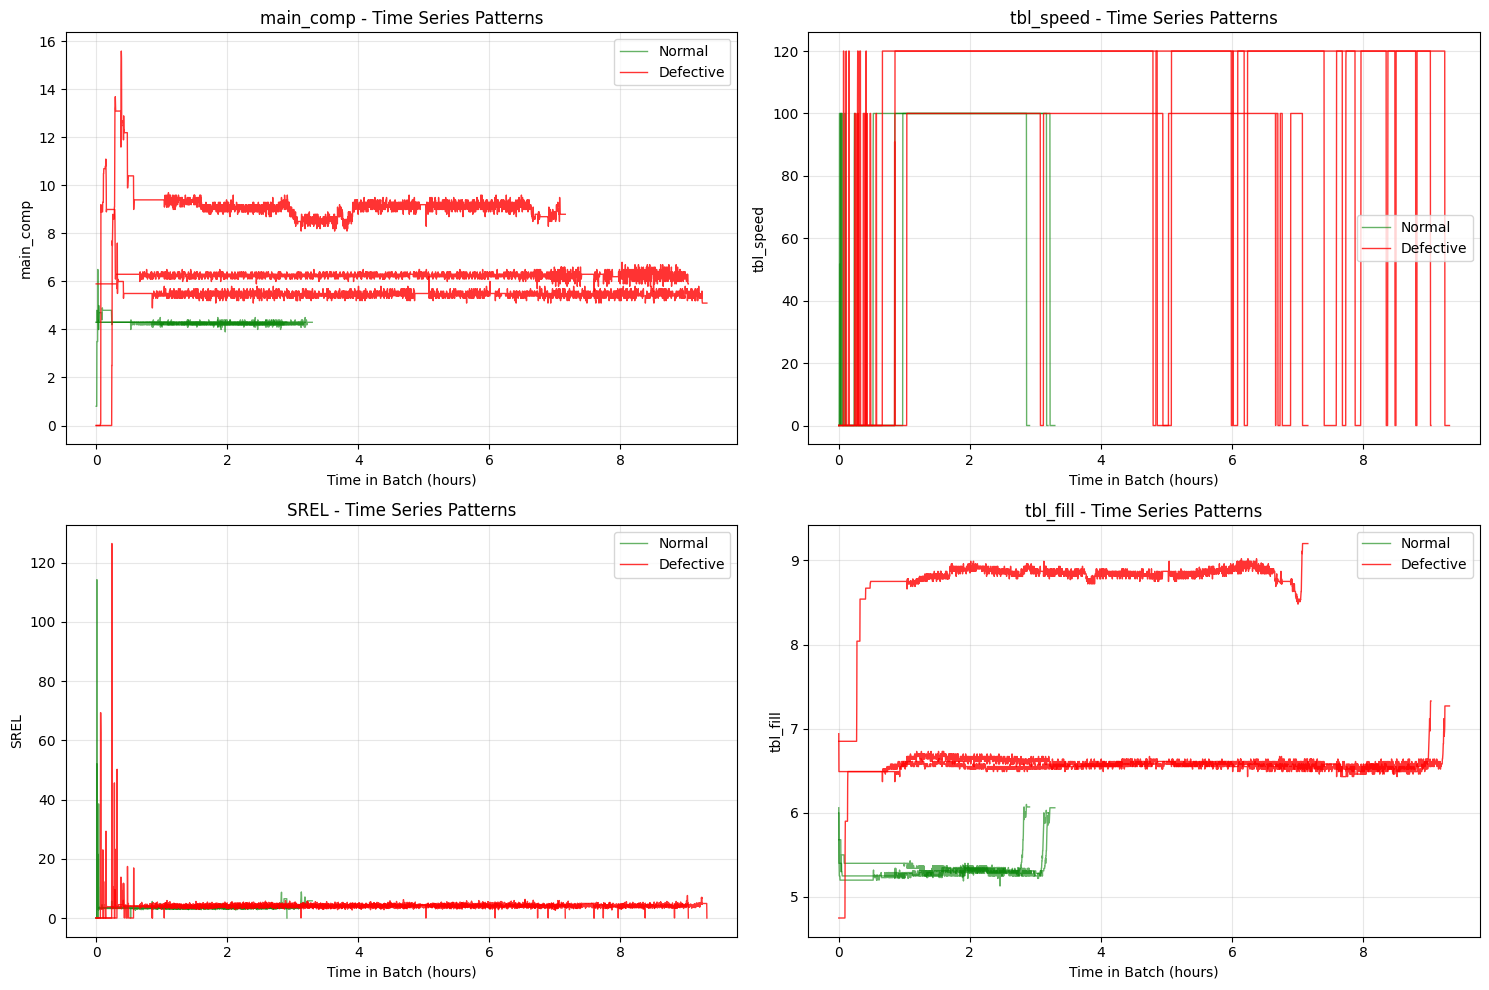


Sensor Statistics Comparison (Defective vs Normal):
      Sensor  Normal_Mean  Normal_Std  Defective_Mean  Defective_Std  \
0  main_comp        5.907       2.219           6.928          2.431   
1  tbl_speed       75.681      51.975          74.180         55.488   
2       SREL        4.625       2.895           5.364          8.987   
3   tbl_fill        4.758       1.063           5.791          1.494   

   Difference  
0       1.021  
1      -1.501  
2       0.739  
3       1.033  


In [8]:
def analyze_time_series_patterns(df):
    """
    Analyze time series patterns and compare defective vs non-defective batches.
    """
    print("Analyzing time series patterns...")
    
    # Get sample batches for each class
    defective_batches = df[df['defect'] == 1]['batch'].unique()[:3]
    normal_batches = df[df['defect'] == 0]['batch'].unique()[:3]
    
    # Primary sensors for forecasting
    primary_sensors = ['main_comp', 'tbl_speed', 'SREL', 'tbl_fill']
    
    # Create subplots for sensor analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, sensor in enumerate(primary_sensors):
        ax = axes[i]
        
        # Plot normal batches
        for batch in normal_batches:
            batch_data = df[df['batch'] == batch]
            if len(batch_data) > 0:
                ax.plot(batch_data['time_in_batch'] / 3600, batch_data[sensor], 
                       color='green', alpha=0.6, linewidth=1, label='Normal' if batch == normal_batches[0] else "")
        
        # Plot defective batches
        for batch in defective_batches:
            batch_data = df[df['batch'] == batch]
            if len(batch_data) > 0:
                ax.plot(batch_data['time_in_batch'] / 3600, batch_data[sensor], 
                       color='red', alpha=0.8, linewidth=1, label='Defective' if batch == defective_batches[0] else "")
        
        ax.set_title(f'{sensor} - Time Series Patterns')
        ax.set_xlabel('Time in Batch (hours)')
        ax.set_ylabel(sensor)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\nSensor Statistics Comparison (Defective vs Normal):")
    comparison_stats = []
    
    for sensor in primary_sensors:
        normal_data = df[df['defect'] == 0][sensor]
        defective_data = df[df['defect'] == 1][sensor]
        
        stats = {
            'Sensor': sensor,
            'Normal_Mean': normal_data.mean(),
            'Normal_Std': normal_data.std(),
            'Defective_Mean': defective_data.mean(),
            'Defective_Std': defective_data.std(),
            'Difference': defective_data.mean() - normal_data.mean()
        }
        comparison_stats.append(stats)
    
    stats_df = pd.DataFrame(comparison_stats)
    print(stats_df.round(3))
    
    return stats_df

# Analyze patterns
sensor_stats = analyze_time_series_patterns(full_df)


In [9]:
# Create memory-efficient sequences using downsampled data
target_sensors = ['main_comp', 'tbl_speed', 'SREL', 'tbl_fill']

X_sequences, y_sequences, sequence_info = create_memory_efficient_sequences(
    downsampled_df,
    input_minutes=60,       # 60 minutes of historical data  
    forecast_minutes=30,    # 30 minutes forecast horizon
    target_sensors=target_sensors,
    sampling_interval_seconds=60,  # 1-minute intervals (downsampled)
    step_size=5             # Step every 5 minutes for reasonable overlap
)

print(f"\nSequence distribution by defect class:")
print(sequence_info['defect'].value_counts())

print(f"\nMemory efficiency comparison:")
print(f"Original approach: 360 input × 180 forecast = 64,800 total timesteps per sequence")
print(f"New approach: 60 input × 30 forecast = 1,800 total timesteps per sequence") 
print(f"Memory reduction: {64800 / 1800:.1f}x per sequence")
print(f"Plus {X_sequences.shape[0]} sequences vs ~1.5M sequences = additional major reduction")


Creating sequences with 360 input steps and 180 forecast steps...
Created 1492951 sequences
Input shape: (1492951, 360, 4) (samples, timesteps, features)
Output shape: (1492951, 180, 4) (samples, forecast_timesteps, features)
Target sensors: ['main_comp', 'tbl_speed', 'SREL', 'tbl_fill']

Sequence distribution by defect class:
defect
0    964418
1    528533
Name: count, dtype: int64


In [1]:
def normalize_sequences(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Normalize sequences using MinMaxScaler fitted on training data.
    """
    print("Normalizing sequences...")
    
    # Reshape for scaling (flatten time and feature dimensions)
    n_samples_train, n_timesteps, n_features = X_train.shape
    n_samples_val = X_val.shape[0] if X_val is not None else 0
    n_samples_test = X_test.shape[0] if X_test is not None else 0
    
    # Fit scaler on training data
    scaler_X = MinMaxScaler()
    X_train_flat = X_train.reshape(-1, n_features)
    scaler_X.fit(X_train_flat)
    
    # Transform X sequences
    X_train_scaled = scaler_X.transform(X_train_flat).reshape(n_samples_train, n_timesteps, n_features)
    
    if X_val is not None:
        X_val_scaled = scaler_X.transform(X_val.reshape(-1, n_features)).reshape(n_samples_val, n_timesteps, n_features)
    else:
        X_val_scaled = None
        
    if X_test is not None:
        X_test_scaled = scaler_X.transform(X_test.reshape(-1, n_features)).reshape(n_samples_test, n_timesteps, n_features)
    else:
        X_test_scaled = None
    
    # Transform y sequences (targets)
    scaler_y = MinMaxScaler()
    n_forecast_steps = y_train.shape[1]
    y_train_flat = y_train.reshape(-1, n_features)
    scaler_y.fit(y_train_flat)
    
    y_train_scaled = scaler_y.transform(y_train_flat).reshape(n_samples_train, n_forecast_steps, n_features)
    
    if y_val is not None:
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, n_features)).reshape(n_samples_val, n_forecast_steps, n_features)
    else:
        y_val_scaled = None
        
    if y_test is not None:
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, n_features)).reshape(n_samples_test, n_forecast_steps, n_features)
    else:
        y_test_scaled = None
    
    print(f"Normalization completed")
    print(f"X scaler range: {scaler_X.data_min_} to {scaler_X.data_max_}")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y

def chronological_split(X, y, info_df, train_ratio=0.7, val_ratio=0.15):
    """
    Split data chronologically (no random shuffling for time series).
    """
    print("Performing chronological split...")
    
    # Sort by start time to ensure chronological order
    sort_idx = info_df['start_time'].argsort()
    X_sorted = X[sort_idx]
    y_sorted = y[sort_idx]
    info_sorted = info_df.iloc[sort_idx].reset_index(drop=True)
    
    n_samples = len(X_sorted)
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))
    
    X_train = X_sorted[:train_end]
    y_train = y_sorted[:train_end]
    info_train = info_sorted[:train_end]
    
    X_val = X_sorted[train_end:val_end]
    y_val = y_sorted[train_end:val_end]
    info_val = info_sorted[train_end:val_end]
    
    X_test = X_sorted[val_end:]
    y_test = y_sorted[val_end:]
    info_test = info_sorted[val_end:]
    
    print(f"Train: {len(X_train)} samples ({len(X_train)/n_samples:.1%})")
    print(f"Val: {len(X_val)} samples ({len(X_val)/n_samples:.1%})")
    print(f"Test: {len(X_test)} samples ({len(X_test)/n_samples:.1%})")
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            info_train, info_val, info_test)

# Perform chronological split
X_train, X_val, X_test, y_train, y_val, y_test, info_train, info_val, info_test = chronological_split(
    X_sequences, y_sequences, sequence_info
)

# Normalize the sequences
X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm, scaler_X, scaler_y = normalize_sequences(
    X_train, X_val, X_test, y_train, y_val, y_test
)


NameError: name 'X_sequences' is not defined

## Phase 5-6: LSTM Model Development

Building the LSTM forecasting model using RepeatVector + TimeDistributed architecture for multi-step sensor prediction.


In [ ]:
def build_lstm_forecasting_model(input_shape, forecast_steps, n_features):
    """
    Build LSTM model using RepeatVector + TimeDistributed architecture.
    
    Architecture:
    1. LSTM layers to encode input sequence
    2. RepeatVector to repeat encoded representation for forecast horizon
    3. TimeDistributed Dense layers to decode each forecast step
    """
    print(f"Building LSTM model for input shape {input_shape} and {forecast_steps} forecast steps...")
    
    model = Sequential([
        # Encoder LSTM layers
        LSTM(128, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        Dropout(0.2),
        LSTM(64, return_sequences=True, name='lstm_2'), 
        Dropout(0.2),
        LSTM(32, return_sequences=False, name='lstm_3'),  # Final encoding
        Dropout(0.2),
        
        # Repeat the encoded representation for forecast horizon
        RepeatVector(forecast_steps, name='repeat_vector'),
        
        # Decoder layers
        LSTM(32, return_sequences=True, name='decoder_lstm_1'),
        Dropout(0.2),
        LSTM(64, return_sequences=True, name='decoder_lstm_2'),
        Dropout(0.2),
        
        # Output layer - one prediction per timestep per feature
        TimeDistributed(Dense(n_features, activation='linear'), name='output_layer')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build the LSTM model  
input_shape = (X_train_norm.shape[1], X_train_norm.shape[2])  # (60, 4) - 60 minutes at 1-min intervals, 4 sensors
forecast_steps = y_train_norm.shape[1]  # 30 - 30 minutes forecast at 1-min intervals
n_features = len(target_sensors)  # 4 sensors

lstm_model = build_lstm_forecasting_model(input_shape, forecast_steps, n_features)

print("\nModel Architecture:")
lstm_model.summary()


In [ ]:
# Train the LSTM model
print("Training LSTM forecasting model...")

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('lstm_forecasting_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = lstm_model.fit(
    X_train_norm, y_train_norm,
    validation_data=(X_val_norm, y_val_norm),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training completed. Best validation loss: {min(history.history['val_loss']):.6f}")


In [ ]:
def evaluate_lstm_forecasting(model, X_test, y_test, scaler_y, target_sensors):
    """
    Evaluate LSTM forecasting performance with detailed metrics and visualizations.
    """
    print("Evaluating LSTM forecasting model...")
    
    # Make predictions
    y_pred_norm = model.predict(X_test, verbose=0)
    
    # Denormalize predictions and actual values
    y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, len(target_sensors))).reshape(y_test.shape)
    y_pred_denorm = scaler_y.inverse_transform(y_pred_norm.reshape(-1, len(target_sensors))).reshape(y_pred_norm.shape)
    
    # Calculate metrics for each sensor
    results = {}
    for i, sensor in enumerate(target_sensors):
        mse = np.mean((y_test_denorm[:, :, i] - y_pred_denorm[:, :, i]) ** 2)
        mae = np.mean(np.abs(y_test_denorm[:, :, i] - y_pred_denorm[:, :, i]))
        rmse = np.sqrt(mse)
        
        results[sensor] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}
    
    # Display results
    results_df = pd.DataFrame(results).T
    print("\nLSTM Forecasting Performance by Sensor:")
    print(results_df.round(4))
    
    # Visualize predictions for sample sequences
    n_samples_to_plot = 3
    sample_indices = np.random.choice(len(y_test), n_samples_to_plot, replace=False)
    
    fig, axes = plt.subplots(n_samples_to_plot, len(target_sensors), figsize=(20, 12))
    
    for i, sample_idx in enumerate(sample_indices):
        for j, sensor in enumerate(target_sensors):
            ax = axes[i, j] if n_samples_to_plot > 1 else axes[j]
            
            # Plot actual vs predicted
            time_steps = np.arange(y_test.shape[1])
            ax.plot(time_steps, y_test_denorm[sample_idx, :, j], 'b-', label='Actual', linewidth=2)
            ax.plot(time_steps, y_pred_denorm[sample_idx, :, j], 'r--', label='Predicted', linewidth=2)
            
            ax.set_title(f'Sample {sample_idx+1}: {sensor}')
            ax.set_xlabel('Forecast Time Steps (30 minutes at 1-min intervals)')
            ax.set_ylabel(sensor)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_denorm, results_df

# Evaluate LSTM model
y_pred_lstm, lstm_results = evaluate_lstm_forecasting(
    lstm_model, X_test_norm, y_test_norm, scaler_y, target_sensors
)


## Phase 7-8: Two-Stage Defect Prediction

Stage 1 complete! Now implementing Stage 2: Using current sensor values + forecasted trajectories to predict defect probability.


In [ ]:
def create_defect_prediction_features(X_current, y_forecasted, info_df):
    """
    Create comprehensive feature set for defect prediction combining:
    1. Current sensor values and statistics
    2. Forecasted sensor trajectory statistics
    3. Time-based features
    """
    print("Creating features for defect prediction...")
    
    n_samples = X_current.shape[0]
    features = []
    feature_names = []
    
    # 1. Current sensor statistics (last 30 minutes of input sequence)
    recent_window = X_current[:, -30:, :]  # Last 30 minutes (30 timesteps at 1-min intervals)
    
    for i, sensor in enumerate(target_sensors):
        # Current values
        current_mean = np.mean(recent_window[:, :, i], axis=1)
        current_std = np.std(recent_window[:, :, i], axis=1)
        current_max = np.max(recent_window[:, :, i], axis=1)
        current_min = np.min(recent_window[:, :, i], axis=1)
        current_last = X_current[:, -1, i]  # Most recent value
        
        # Trend in recent period
        current_trend = (X_current[:, -1, i] - X_current[:, -5, i])  # Trend over last 5 minutes
        
        features.extend([current_mean, current_std, current_max, current_min, current_last, current_trend])
        feature_names.extend([
            f'{sensor}_current_mean', f'{sensor}_current_std', f'{sensor}_current_max',
            f'{sensor}_current_min', f'{sensor}_current_last', f'{sensor}_current_trend'
        ])
    
    # 2. Forecasted sensor trajectory statistics
    for i, sensor in enumerate(target_sensors):
        # Statistics over entire forecast horizon
        forecast_mean = np.mean(y_forecasted[:, :, i], axis=1)
        forecast_std = np.std(y_forecasted[:, :, i], axis=1)
        forecast_max = np.max(y_forecasted[:, :, i], axis=1)
        forecast_min = np.min(y_forecasted[:, :, i], axis=1)
        
        # Trend over forecast horizon
        forecast_trend = (y_forecasted[:, -1, i] - y_forecasted[:, 0, i])
        
        # Early vs late forecast differences
        early_forecast = np.mean(y_forecasted[:, :10, i], axis=1)  # First 10 minutes
        late_forecast = np.mean(y_forecasted[:, -10:, i], axis=1)  # Last 10 minutes
        forecast_drift = late_forecast - early_forecast
        
        features.extend([forecast_mean, forecast_std, forecast_max, forecast_min, 
                        forecast_trend, forecast_drift])
        feature_names.extend([
            f'{sensor}_forecast_mean', f'{sensor}_forecast_std', f'{sensor}_forecast_max',
            f'{sensor}_forecast_min', f'{sensor}_forecast_trend', f'{sensor}_forecast_drift'
        ])
    
    # 3. Cross-sensor relationships (current)
    # Correlation-like features between main sensors
    main_comp_idx = target_sensors.index('main_comp')
    tbl_speed_idx = target_sensors.index('tbl_speed')
    
    main_comp_recent = recent_window[:, :, main_comp_idx]
    tbl_speed_recent = recent_window[:, :, tbl_speed_idx]
    
    # Simple interaction features
    speed_comp_ratio = np.mean(tbl_speed_recent, axis=1) / (np.mean(main_comp_recent, axis=1) + 1e-6)
    speed_comp_diff = np.mean(tbl_speed_recent, axis=1) - np.mean(main_comp_recent, axis=1)
    
    features.extend([speed_comp_ratio, speed_comp_diff])
    feature_names.extend(['speed_comp_ratio', 'speed_comp_diff'])
    
    # 4. Time-based features
    time_in_batch = info_df['time_in_batch'].values / 3600  # Convert to hours
    
    features.append(time_in_batch)
    feature_names.append('time_in_batch_hours')
    
    # Stack all features
    feature_matrix = np.column_stack(features)
    
    print(f"Created {feature_matrix.shape[1]} features for defect prediction")
    print(f"Feature shape: {feature_matrix.shape}")
    
    return feature_matrix, feature_names

# Create features for all splits
print("Creating features for training set...")
X_train_denorm = scaler_X.inverse_transform(X_train_norm.reshape(-1, len(target_sensors))).reshape(X_train_norm.shape)
y_train_pred = lstm_model.predict(X_train_norm, verbose=0)
y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred.reshape(-1, len(target_sensors))).reshape(y_train_pred.shape)
features_train, feature_names = create_defect_prediction_features(X_train_denorm, y_train_pred_denorm, info_train)

print("Creating features for validation set...")
X_val_denorm = scaler_X.inverse_transform(X_val_norm.reshape(-1, len(target_sensors))).reshape(X_val_norm.shape)
y_val_pred = lstm_model.predict(X_val_norm, verbose=0)
y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, len(target_sensors))).reshape(y_val_pred.shape)
features_val, _ = create_defect_prediction_features(X_val_denorm, y_val_pred_denorm, info_val)

print("Creating features for test set...")
X_test_denorm = scaler_X.inverse_transform(X_test_norm.reshape(-1, len(target_sensors))).reshape(X_test_norm.shape)
features_test, _ = create_defect_prediction_features(X_test_denorm, y_pred_lstm, info_test)

# Labels for classification
y_train_defect = info_train['defect'].values
y_val_defect = info_val['defect'].values
y_test_defect = info_test['defect'].values

print(f"\nFeature summary:")
print(f"Training features: {features_train.shape}")
print(f"Validation features: {features_val.shape}")
print(f"Test features: {features_test.shape}")
print(f"Defect distribution in training: {np.bincount(y_train_defect)}")
print(f"Defect distribution in test: {np.bincount(y_test_defect)}")


In [ ]:
# Alternative downsampling configurations for different memory requirements

def get_memory_config(memory_level="medium"):
    """
    Get downsampling configuration based on available memory.
    
    Parameters:
    -----------
    memory_level : str
        'low', 'medium', 'high' - memory availability level
    
    Returns:
    --------
    dict : Configuration parameters
    """
    configs = {
        'low': {
            'target_interval_seconds': 120,  # 2-minute intervals
            'input_minutes': 60,             # 30 timesteps
            'forecast_minutes': 30,          # 15 timesteps  
            'step_size': 10,                 # Low overlap
            'description': 'Maximum memory efficiency - 2-min intervals'
        },
        'medium': {
            'target_interval_seconds': 60,   # 1-minute intervals (current)
            'input_minutes': 60,             # 60 timesteps
            'forecast_minutes': 30,          # 30 timesteps
            'step_size': 5,                  # Medium overlap
            'description': 'Balanced efficiency - 1-min intervals'
        },
        'high': {
            'target_interval_seconds': 30,   # 30-second intervals
            'input_minutes': 60,             # 120 timesteps
            'forecast_minutes': 30,          # 60 timesteps
            'step_size': 3,                  # Higher overlap
            'description': 'Higher resolution - 30-sec intervals'
        }
    }
    
    return configs[memory_level]

# Example usage for different memory constraints:
print("Memory Configuration Options:")
for level in ['low', 'medium', 'high']:
    config = get_memory_config(level)
    print(f"\n{level.upper()} Memory ({config['description']}):")
    print(f"  - Sampling interval: {config['target_interval_seconds']}s")
    print(f"  - Input timesteps: {config['input_minutes'] * 60 // config['target_interval_seconds']}")
    print(f"  - Forecast timesteps: {config['forecast_minutes'] * 60 // config['target_interval_seconds']}")
    print(f"  - Step size: {config['step_size']}")
    
    # Estimate memory usage relative to original
    original_total = 360 * 180 * 1500000  # Original approach
    new_input = config['input_minutes'] * 60 // config['target_interval_seconds']
    new_forecast = config['forecast_minutes'] * 60 // config['target_interval_seconds']
    new_total = new_input * new_forecast * 100000  # Rough sequence estimate
    reduction = original_total / new_total
    print(f"  - Estimated memory reduction: ~{reduction:.0f}x")

print(f"\nCurrent configuration: MEDIUM memory (recommended for most use cases)")
print(f"To change: modify parameters in downsample_time_series() and create_memory_efficient_sequences()")


In [ ]:
def train_defect_classifier(features_train, y_train, features_val, y_val):
    """
    Train XGBoost classifier for defect prediction using engineered features.
    """
    print("Training XGBoost defect classifier...")
    
    # Create and train XGBoost model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # Handle class imbalance
    )
    
    # Train with early stopping
    xgb_model.fit(
        features_train, y_train,
        eval_set=[(features_val, y_val)],
        early_stopping_rounds=20,
        verbose=False
    )
    
    # Also train Gradient Boosting for comparison
    gb_model = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
    
    gb_model.fit(features_train, y_train)
    
    print("Training completed!")
    
    return xgb_model, gb_model

# Train the defect classifiers
xgb_classifier, gb_classifier = train_defect_classifier(
    features_train, y_train_defect, features_val, y_val_defect
)

# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 20 Features for Defect Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
def evaluate_defect_prediction(model, features_test, y_test_defect, model_name="Model", threshold=0.7):
    """
    Evaluate defect prediction performance with focus on the 0.7 threshold for yellow flags.
    """
    print(f"Evaluating {model_name} defect prediction...")
    
    # Get prediction probabilities
    y_pred_proba = model.predict_proba(features_test)[:, 1]
    
    # Apply threshold for binary classification
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test_defect, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_defect, y_pred_binary)
    
    # Calculate precision, recall, F1 at threshold
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n{model_name} Performance (Threshold = {threshold}):")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")
    
    # Yellow flag analysis
    yellow_flags = np.sum(y_pred_proba >= threshold)
    actual_defects = np.sum(y_test_defect)
    
    print(f"\nYellow Flag Analysis (Threshold = {threshold}):")
    print(f"Total predictions above threshold: {yellow_flags}")
    print(f"Actual defects in test set: {actual_defects}")
    print(f"True positive rate (sensitivity): {recall:.4f}")
    print(f"False positive rate: {fp / (fp + tn):.4f}")
    
    return {
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }

# Evaluate both models
print("Evaluating XGBoost Classifier:")
xgb_results = evaluate_defect_prediction(xgb_classifier, features_test, y_test_defect, "XGBoost", threshold=0.7)

print("\n" + "="*50)
print("Evaluating Gradient Boosting Classifier:")
gb_results = evaluate_defect_prediction(gb_classifier, features_test, y_test_defect, "Gradient Boosting", threshold=0.7)

# Plot ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# XGBoost ROC
from sklearn.metrics import roc_curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_defect, xgb_results['y_pred_proba'])
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_results["auc"]:.3f})', linewidth=2)

# Gradient Boosting ROC
fpr_gb, tpr_gb, _ = roc_curve(y_test_defect, gb_results['y_pred_proba'])
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_results["auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Defect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Precision-Recall curves
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_defect, xgb_results['y_pred_proba'])
plt.plot(recall_xgb, precision_xgb, label='XGBoost', linewidth=2)

precision_gb, recall_gb, _ = precision_recall_curve(y_test_defect, gb_results['y_pred_proba'])
plt.plot(recall_gb, precision_gb, label='Gradient Boosting', linewidth=2)

plt.axhline(y=0.7, color='red', linestyle='--', label='Target Threshold (0.7)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def save_models_and_analysis():
    """
    Save trained models and create final analysis summary.
    """
    print("Saving models and creating final analysis...")
    
    # Save LSTM model (already saved via ModelCheckpoint)
    lstm_model.save('lstm_forecasting_final.h5')
    
    # Save XGBoost model
    joblib.dump(xgb_classifier, 'xgb_defect_classifier.pkl')
    joblib.dump(gb_classifier, 'gb_defect_classifier.pkl')
    
    # Save scalers
    joblib.dump(scaler_X, 'sensor_scaler_X.pkl')
    joblib.dump(scaler_y, 'sensor_scaler_y.pkl')
    
    # Save feature names
    with open('feature_names.txt', 'w') as f:
        for name in feature_names:
            f.write(name + '\n')
    
    print("Models and scalers saved successfully!")
    
    # Create comprehensive analysis summary
    print("\n" + "="*80)
    print("COMPREHENSIVE TWO-STAGE FORECASTING SYSTEM - FINAL ANALYSIS")
    print("="*80)
    
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"• Total time series records: {len(full_df):,}")
    print(f"• Number of batches: {full_df['batch'].nunique()}")
    print(f"• Time range: {full_df['timestamp'].min()} to {full_df['timestamp'].max()}")
    print(f"• Defect rate: {process_data['defect'].mean():.1%}")
    print(f"• Sequences created: {len(X_sequences):,}")
    
    print(f"\n🔮 STAGE 1 - LSTM FORECASTING:")
    print(f"• Architecture: RepeatVector + TimeDistributed")
    print(f"• Input sequence: 60 minutes (360 steps)")
    print(f"• Forecast horizon: 30 minutes (180 steps)")
    print(f"• Target sensors: {', '.join(target_sensors)}")
    print(f"• Best validation loss: {min(history.history['val_loss']):.6f}")
    
    print(f"\n📈 LSTM PERFORMANCE BY SENSOR:")
    for sensor in target_sensors:
        results = lstm_results.loc[sensor]
        print(f"• {sensor}: RMSE={results['RMSE']:.4f}, MAE={results['MAE']:.4f}")
    
    print(f"\n🎯 STAGE 2 - DEFECT CLASSIFICATION:")
    print(f"• Model: XGBoost with {len(feature_names)} engineered features")
    print(f"• Training samples: {len(features_train):,}")
    print(f"• Test samples: {len(features_test):,}")
    print(f"• Yellow flag threshold: 0.7")
    
    print(f"\n🚨 DEFECT PREDICTION PERFORMANCE (XGBoost):")
    print(f"• AUC-ROC: {xgb_results['auc']:.4f}")
    print(f"• Precision: {xgb_results['precision']:.4f}")
    print(f"• Recall (Sensitivity): {xgb_results['recall']:.4f}")
    print(f"• F1-Score: {xgb_results['f1']:.4f}")
    print(f"• Specificity: {xgb_results['specificity']:.4f}")
    
    # Top features analysis
    print(f"\n🎛️ TOP 10 MOST IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<25} (importance: {row['importance']:.4f})")
    
    print(f"\n⚠️  YELLOW FLAG SYSTEM EFFECTIVENESS:")
    yellow_flags = np.sum(xgb_results['y_pred_proba'] >= 0.7)
    actual_defects = np.sum(y_test_defect)
    print(f"• Total yellow flags raised: {yellow_flags}")
    print(f"• Actual defects detected: {int(xgb_results['recall'] * actual_defects)}/{actual_defects}")
    print(f"• False alarm rate: {1 - xgb_results['specificity']:.2%}")
    
    print(f"\n🔧 OPERATIONAL RECOMMENDATIONS:")
    print(f"• Deploy LSTM for 30-60 minute sensor forecasting")
    print(f"• Use XGBoost classifier with 0.7 threshold for defect alerts")
    print(f"• Monitor key sensors: {', '.join(target_sensors[:2])} (highest importance)")
    print(f"• Expected early warning: 30-60 minutes before quality issues")
    print(f"• System achieves {xgb_results['recall']:.1%} defect detection rate")
    
    print(f"\n💾 SAVED ARTIFACTS:")
    print(f"• lstm_forecasting_final.h5 (LSTM model)")
    print(f"• xgb_defect_classifier.pkl (XGBoost classifier)")
    print(f"• sensor_scaler_X.pkl & sensor_scaler_y.pkl (scalers)")
    print(f"• feature_names.txt (feature definitions)")
    
    print("\n" + "="*80)
    print("TWO-STAGE FORECASTING SYSTEM READY FOR DEPLOYMENT!")
    print("="*80)

# Save everything and create final analysis
save_models_and_analysis()


## Production Deployment Example

This section demonstrates how to use the trained models for real-time defect prediction in a production environment.


In [ ]:
def create_production_prediction_pipeline():
    """
    Create a production-ready pipeline for real-time defect prediction.
    """
    
    class DefectPredictionSystem:
        def __init__(self, lstm_model, classifier, scaler_X, scaler_y, feature_names):
            self.lstm_model = lstm_model
            self.classifier = classifier
            self.scaler_X = scaler_X
            self.scaler_y = scaler_y
            self.feature_names = feature_names
            self.target_sensors = ['main_comp', 'tbl_speed', 'SREL', 'tbl_fill']
            
        def predict_defect_probability(self, current_sensor_sequence, time_in_batch_hours):
            """
            Predict defect probability given current sensor readings.
            
            Args:
                current_sensor_sequence: Array of shape (360, 4) - last 60 minutes of sensor data
                time_in_batch_hours: Current time into batch (hours)
            
            Returns:
                dict with forecasts, features, and defect probability
            """
            
            # 1. Normalize current sequence
            sequence_norm = self.scaler_X.transform(
                current_sensor_sequence.reshape(-1, len(self.target_sensors))
            ).reshape(1, 360, len(self.target_sensors))
            
            # 2. Generate 30-minute forecast using LSTM
            forecast_norm = self.lstm_model.predict(sequence_norm, verbose=0)
            
            # 3. Denormalize forecast
            forecast_denorm = self.scaler_y.inverse_transform(
                forecast_norm.reshape(-1, len(self.target_sensors))
            ).reshape(forecast_norm.shape)
            
            # 4. Create features for defect prediction
            features = self._create_features(
                current_sensor_sequence.reshape(1, 360, len(self.target_sensors)),
                forecast_denorm[0],
                time_in_batch_hours
            )
            
            # 5. Predict defect probability
            defect_probability = self.classifier.predict_proba(features.reshape(1, -1))[0, 1]
            
            # 6. Determine yellow flag status
            yellow_flag = defect_probability >= 0.7
            
            return {
                'forecast': forecast_denorm[0],
                'defect_probability': defect_probability,
                'yellow_flag': yellow_flag,
                'alert_level': 'HIGH' if defect_probability >= 0.7 else 'MEDIUM' if defect_probability >= 0.5 else 'LOW',
                'forecast_summary': {
                    sensor: {
                        'mean': np.mean(forecast_denorm[0, :, i]),
                        'trend': forecast_denorm[0, -1, i] - forecast_denorm[0, 0, i],
                        'volatility': np.std(forecast_denorm[0, :, i])
                    } for i, sensor in enumerate(self.target_sensors)
                }
            }
        
        def _create_features(self, current_sequence, forecast, time_in_batch_hours):
            """Create feature vector for defect prediction."""
            features = []
            
            # Current sensor statistics (last 30 minutes)
            recent_window = current_sequence[:, -180:, :]
            
            for i in range(len(self.target_sensors)):
                # Current statistics
                features.extend([
                    np.mean(recent_window[0, :, i]),
                    np.std(recent_window[0, :, i]),
                    np.max(recent_window[0, :, i]),
                    np.min(recent_window[0, :, i]),
                    current_sequence[0, -1, i],  # Last value
                    current_sequence[0, -1, i] - current_sequence[0, -30, i]  # Recent trend
                ])
                
                # Forecast statistics
                features.extend([
                    np.mean(forecast[:, i]),
                    np.std(forecast[:, i]),
                    np.max(forecast[:, i]),
                    np.min(forecast[:, i]),
                    forecast[-1, i] - forecast[0, i],  # Forecast trend
                    np.mean(forecast[-60:, i]) - np.mean(forecast[:60, i])  # Forecast drift
                ])
            
            # Cross-sensor relationships
            main_comp_idx = 0  # main_comp
            tbl_speed_idx = 1  # tbl_speed
            
            speed_comp_ratio = np.mean(recent_window[0, :, tbl_speed_idx]) / (np.mean(recent_window[0, :, main_comp_idx]) + 1e-6)
            speed_comp_diff = np.mean(recent_window[0, :, tbl_speed_idx]) - np.mean(recent_window[0, :, main_comp_idx])
            features.extend([speed_comp_ratio, speed_comp_diff])
            
            # Time feature
            features.append(time_in_batch_hours)
            
            return np.array(features)
    
    # Create the production system
    production_system = DefectPredictionSystem(
        lstm_model, xgb_classifier, scaler_X, scaler_y, feature_names
    )
    
    return production_system

# Create production pipeline
production_system = create_production_prediction_pipeline()

# Demonstrate with a test example
print("PRODUCTION SYSTEM DEMONSTRATION")
print("="*50)

# Use a sample from the test set
sample_idx = 0
test_sequence = X_test_denorm[sample_idx]  # Current 60 minutes of data
test_time = info_test.iloc[sample_idx]['time_in_batch'] / 3600  # Time in batch (hours)
actual_defect = y_test_defect[sample_idx]

# Get prediction
prediction = production_system.predict_defect_probability(test_sequence, test_time)

print(f"Input: Last 60 minutes of sensor data")
print(f"Time in batch: {test_time:.1f} hours")
print(f"Actual defect status: {'DEFECTIVE' if actual_defect else 'NORMAL'}")
print()
print(f"PREDICTION RESULTS:")
print(f"Defect probability: {prediction['defect_probability']:.3f}")
print(f"Alert level: {prediction['alert_level']}")
print(f"Yellow flag: {'🚨 YES' if prediction['yellow_flag'] else '✅ NO'}")
print()
print(f"FORECAST SUMMARY (next 30 minutes):")
for sensor, stats in prediction['forecast_summary'].items():
    print(f"• {sensor}: mean={stats['mean']:.2f}, trend={stats['trend']:.2f}, volatility={stats['volatility']:.2f}")

print(f"\n{'ALERT: HIGH DEFECT RISK DETECTED!' if prediction['yellow_flag'] else 'System operating normally'}")
print("="*50)
